In [1]:
import numpy as np
import math
import heapq # for retrieval topK

import scipy.sparse as sp

from keras import initializers
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Embedding, Input, Dense, Multiply, Reshape, Flatten, Concatenate
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG
from time import time

Using TensorFlow backend.


### 参数设定

In [2]:
num_factors = 16 # MF潜因子数量
topK = 5 # topK推荐数量
reg_mf = 0 # MF L2正则化参数
layers = [64, 32, 16, 8] # MLP每层神经元数量
reg_layers = [0,0,0,0] # MLP每层L2正则化参数
num_negatives = 4 # 训练时每个正样本对应的负样本数量
learner = 'adam' # 优化器
learning_rate = 0.001 # 学习率
epochs = 30 # 迭代次数
batch_size = 256
csv_name = 'ml-latest-small/ratings.csv' # 数据集csv文件名称
gmf_model_out_file = 'Pretrain/GMF_%d_%d.h5' %(num_factors, time())
neumf_model_out_file = 'Pretrain/NeuMF_%d_%s_%d.h5' %(num_factors, str(layers), time())

### 载入MovieLens(small)数据集

In [3]:
class Dataset(object):
    # 构造函数
    def __init__(self, filename):
        self.trainMatrix, self.devPositives, self.devNegatives, self.uidx_to_uid, self.iidx_to_iid = self.load_csv_file(filename)
        assert len(self.devPositives) == len(self.devNegatives)
        self.num_users, self.num_items = self.trainMatrix.shape
        
    # 载入并分析csv文件
    def load_csv_file(self, filename):
        uid_to_uidx = {} # 用户id到用户index的映射
        uidx_to_uid = {} # 用户index到用户id的映射
        iid_to_iidx = {} # 影片id到用户index的映射
        iidx_to_iid = {} # 影片index到用户id的映射
        
        # 第一次打开文件，确定用户-影片稀疏矩阵规模，并生成id到index的映射
        with open(filename, "r") as f:
            uidx = 0
            iidx = 0
            line = f.readline()
            line = f.readline()
            while line != None and line != "":
                arr = line.split(",")
                uid, iid = int(arr[0]), int(arr[1])
                if uid not in uid_to_uidx:
                    uid_to_uidx[uid] = uidx
                    uidx_to_uid[uidx] = uid
                    uidx += 1
                if iid not in iid_to_iidx:
                    iid_to_iidx[iid] = iidx
                    iidx_to_iid[iidx] = iid
                    iidx += 1
                line = f.readline()
        
        num_users, num_items = uidx, iidx # 用户数量，影片数量
        
        mat = sp.dok_matrix((num_users, num_items), dtype=np.float32) # 用户-影片稀疏矩阵
        dev_pos = [] # 验证集正样本
        dev_neg = [] # 验证集负样本
        
        # 第二次打开文件，生成用户-影片稀疏矩阵，生成验证集的正负样本数据
        # 采用leave-one-out方法评估，即：对于每个用户，将其最近的一次交互作为验证集的正样本，并利用余下的数据作为训练集
        with open(filename, "r") as f:
            latest_record = {}
            line = f.readline()
            line = f.readline()
            while line != None and line != "":
                arr = line.split(",")
                uid, iid, rating, timestamp = int(arr[0]), int(arr[1]), float(arr[2])/5., int(arr[3])
                uidx, iidx = uid_to_uidx[uid], iid_to_iidx[iid]
                if uidx not in latest_record:
                    latest_record[uidx] = [iidx, timestamp, 1]
                elif timestamp > latest_record[uidx][1]:
                    latest_record[uidx] = [iidx, timestamp, latest_record[uidx][2]+1]
                mat[uidx, iidx] = rating
                line = f.readline()
                
            for uidx in range(num_users):
                if uidx not in latest_record:
                    continue
                latest_iidx, timestamp, count = latest_record[uidx]
                if count < 2:
                    continue
                # 至少观看过两部影片的用户，抽取未观看的99部影片作为负样本，抽取最近一次观看的影片作为正样本
                negs = []
                for t in range(99):
                    neg_iidx = np.random.randint(num_items)
                    while neg_iidx in negs or (uidx, neg_iidx) in mat:
                        neg_iidx = np.random.randint(num_items)
                    negs.append(neg_iidx)
                dev_neg.append([uidx, negs])
                dev_pos.append([uidx, latest_iidx, mat[uidx, latest_iidx]])
                mat[uidx, latest_iidx] = 0 # 将正样本从训练集中去除
        
        return mat, dev_pos, dev_neg, uidx_to_uid, iidx_to_iid

In [4]:
dataset = Dataset(csv_name)
trainMatrix, devPositives, devNegatives = dataset.trainMatrix, dataset.devPositives, dataset.devNegatives
num_users, num_items = dataset.num_users, dataset.num_items
print("Load data done. num_users=%d, num_items=%d, train_size=%d, dev_size=%d" 
      %(num_users, num_items, trainMatrix.nnz, len(devPositives)))

Load data done. num_users=671, num_items=9066, train_size=99347, dev_size=657


### 建立GMF模型

In [5]:
def get_gmf_model(num_users, num_items, latent_dim, reg=0):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim=num_users, 
                                  output_dim=latent_dim, 
                                  embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01), 
                                  embeddings_regularizer=l2(reg), # L2正则化有问题
                                  input_length=1, 
                                  name='user_embedding')
    
    MF_Embedding_Item = Embedding(input_dim=num_items, 
                                  output_dim=latent_dim, 
                                  embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01), 
                                  embeddings_regularizer=l2(reg), # L2正则化有问题
                                  input_length=1, 
                                  name='item_embedding') 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, 
                       activation='sigmoid', 
                       kernel_initializer='lecun_uniform', 
                       name='prediction')(predict_vector)
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)

    return model

In [6]:
gmf_model = get_gmf_model(num_users, num_items, num_factors, reg_mf)

In [7]:
gmf_model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')

In [8]:
# GMF模型结构
gmf_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 16)        10736       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 16)        145056      item_input[0][0]                 
__________________________________________________________________________________________________
flatten_1 

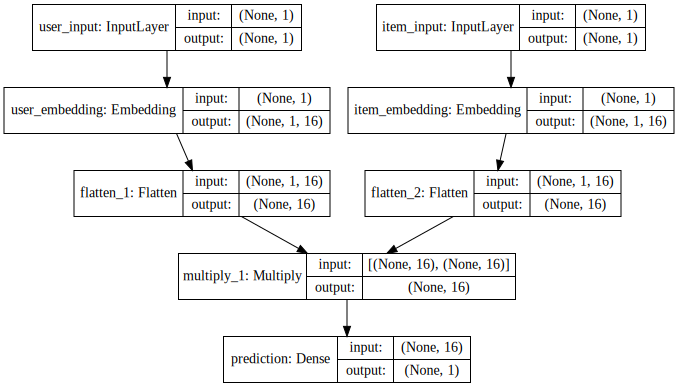

In [9]:
# GMF模型结构图
SVG(model_to_dot(gmf_model, show_shapes=True).create(prog='dot', format='svg'))

### 评估初始模型效果（随机推荐）

In [10]:
# 评估topK推荐的效果
# 返回每个验证集的Hit, NDCG
def evaluate_model(model, devPositives, devNegatives, topK):
    assert len(devPositives) == len(devNegatives)
    
    hits, ndcgs = [],[] # Hit列表，NDCG列表
    for idx in range(len(devPositives)):
        uidx, pos_iidx, rating = devPositives[idx]
        neg_uidx, items = devNegatives[idx]
        assert uidx == neg_uidx
        items.append(pos_iidx)
        hr, ndcg = eval_one_record(model, uidx, pos_iidx, rating, items, topK)
        items.pop()
        hits.append(hr)
        ndcgs.append(ndcg)      
    return hits, ndcgs

# 评估单条验证集记录
def eval_one_record(model, uidx, pos_iidx, rating, items, topK):
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), uidx, dtype = 'int32')
    predictions = model.predict([users, np.array(items)], batch_size=100, verbose=0)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(topK, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, pos_iidx)
    ndcg = getNDCG(ranklist, pos_iidx)
    return hr, ndcg

def getHitRatio(ranklist, pos_iidx):
    return int(pos_iidx in ranklist)

def getNDCG(ranklist, pos_iidx):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == pos_iidx:
            return 0.6931471805599453 / math.log(i + 2) # log(2) = 0.6931471805599453
    return 0

In [11]:
hits, ndcgs = evaluate_model(gmf_model, devPositives, devNegatives, topK)
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('Random: HitRatio = %.4f, NDCG = %.4f' % (hr, ndcg))

Random: HitRatio = 0.0533, NDCG = 0.0302


### 训练GMF模型

In [12]:
# 生成训练样本
def get_train_instances(trainMatrix, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_items = trainMatrix.shape[1]
    for (uidx, iidx) in trainMatrix.keys():
        # 生成训练正样本
        user_input.append(uidx)
        item_input.append(iidx)
        labels.append(trainMatrix[uidx, iidx])
        # 生成训练负样本
        for t in range(num_negatives):
            neg_iidx = np.random.randint(num_items)
            while (uidx, neg_iidx) in trainMatrix:
                neg_iidx = np.random.randint(num_items)
            user_input.append(uidx)
            item_input.append(neg_iidx)
            labels.append(0)
    return user_input, item_input, labels

In [13]:
best_hr = 0
for epoch in range(epochs):
    # 生成训练样本
    user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)
    
    # 训练
    hist = gmf_model.fit([np.array(user_input), np.array(item_input)], # 输入
                     np.array(labels), # 标签
                     batch_size=batch_size, epochs=1, verbose=1, shuffle=True)
    
    # 评估
    hits, ndcgs = evaluate_model(gmf_model, devPositives, devNegatives, topK)
    hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
    print('Epoch %d : HitRatio = %.4f, NDCG = %.4f, loss = %.4f' % (epoch, hr, ndcg, loss))
    if hr > best_hr:
        best_hr = hr
        gmf_model.save_weights(gmf_model_out_file, overwrite=True)

print("The best GMF model is saved to %s" %(gmf_model_out_file))

Epoch 1/1
496735/496735 [==============================] - 6s 12us/step - loss: 0.3977
Epoch 0 : HitRatio = 0.3775, NDCG = 0.2473, loss = 0.3977
Epoch 1/1
496735/496735 [==============================] - 5s 10us/step - loss: 0.2883
Epoch 1 : HitRatio = 0.3699, NDCG = 0.2517, loss = 0.2883
Epoch 1/1
496735/496735 [==============================] - 4s 9us/step - loss: 0.2837
Epoch 2 : HitRatio = 0.3805, NDCG = 0.2537, loss = 0.2837
Epoch 1/1
496735/496735 [==============================] - 4s 9us/step - loss: 0.2750
Epoch 3 : HitRatio = 0.4018, NDCG = 0.2686, loss = 0.2750
Epoch 1/1
496735/496735 [==============================] - 4s 9us/step - loss: 0.2589
Epoch 4 : HitRatio = 0.4155, NDCG = 0.2843, loss = 0.2589
Epoch 1/1
496735/496735 [==============================] - 4s 9us/step - loss: 0.2475
Epoch 5 : HitRatio = 0.4444, NDCG = 0.3020, loss = 0.2475
Epoch 1/1
496735/496735 [==============================] - 4s 9us/step - loss: 0.2382
Epoch 6 : HitRatio = 0.4658, NDCG = 0.3190, loss

### 评估GMF模型效果

In [14]:
gmf_model.load_weights(gmf_model_out_file) # 载入GMF模型权重
hits, ndcgs = evaluate_model(gmf_model, devPositives, devNegatives, topK)
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('GMF: HitRatio = %.4f, NDCG = %.4f' % (hr, ndcg))

GMF: HitRatio = 0.5540, NDCG = 0.3863


### 建立NeuMF模型

In [15]:
def get_neumf_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # MLP层数
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim=num_users, 
                                  output_dim=mf_dim, 
                                  embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01), 
                                  embeddings_regularizer=l2(reg_mf), 
                                  input_length=1, 
                                  name='mf_embedding_user')
    MF_Embedding_Item = Embedding(input_dim=num_items, 
                                  output_dim=mf_dim, 
                                  embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01), 
                                  embeddings_regularizer=l2(reg_mf), 
                                  input_length=1, 
                                  name='mf_embedding_item')
    
    MLP_Embedding_User = Embedding(input_dim=num_users, 
                                   output_dim=layers[0]//2, 
                                   embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01), 
                                   embeddings_regularizer=l2(reg_layers[0]), 
                                   input_length=1, 
                                   name='mlp_embedding_user')
    MLP_Embedding_Item = Embedding(input_dim=num_items, 
                                   output_dim=layers[0]//2, 
                                   embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01), 
                                   embeddings_regularizer=l2(reg_layers[0]), 
                                   input_length=1, 
                                   name='mlp_embedding_item')
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], 
                      activation='relu', 
                      kernel_regularizer=l2(reg_layers[idx]), 
                      name="layer%d"%idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, 
                       activation='sigmoid', 
                       kernel_initializer='lecun_uniform', 
                       name='prediction')(predict_vector)
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    
    return model

In [16]:
neumf_model = get_neumf_model(num_users, num_items, num_factors, layers, reg_layers, reg_mf)

In [17]:
neumf_model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')

In [18]:
# NeuMF模型结构
neumf_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 32)        21472       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 32)        290112      item_input[0][0]                 
__________________________________________________________________________________________________
flatten_5 

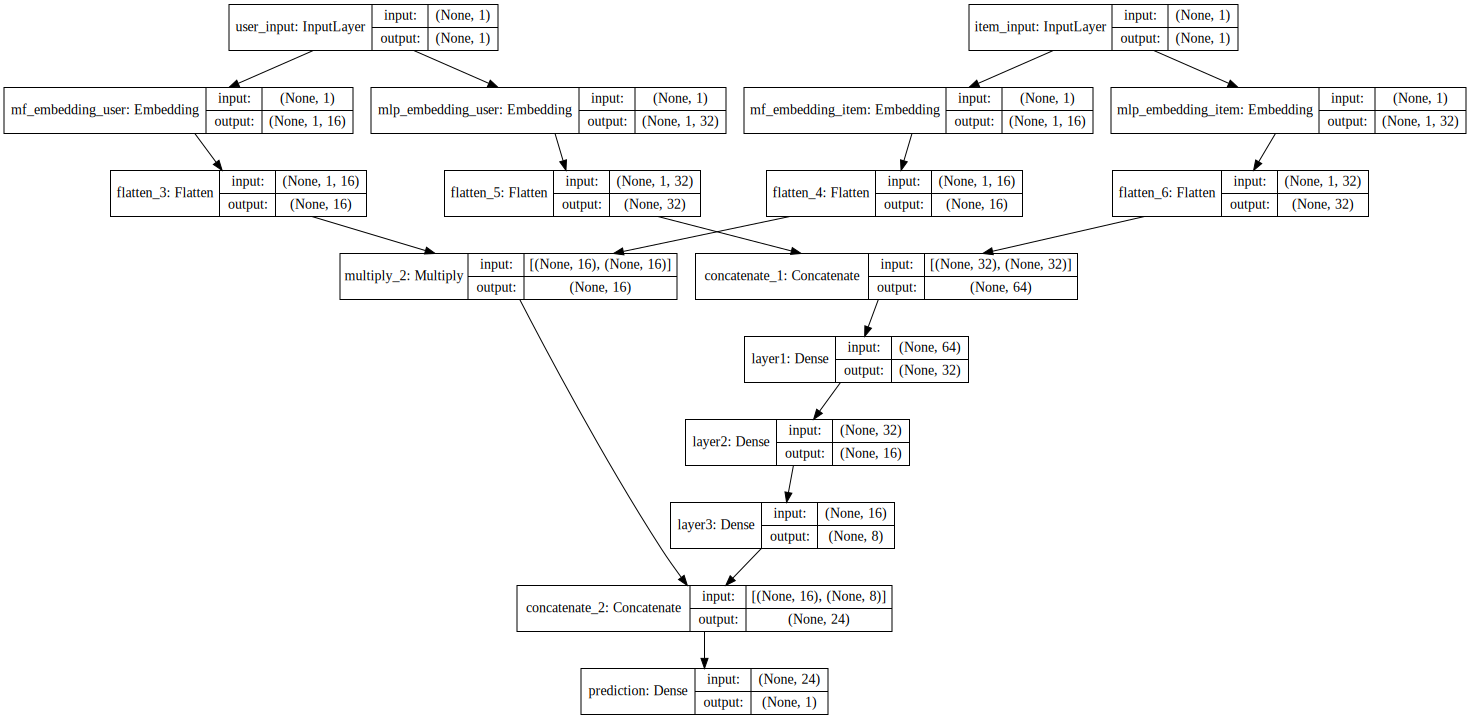

In [19]:
# NeuMF模型结构图
SVG(model_to_dot(neumf_model, show_shapes=True).create(prog='dot', format='svg'))

### 训练NeuMF模型

In [20]:
best_hr = 0
for epoch in range(epochs):
    # 生成训练样本
    user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)
    
    # 训练
    hist = neumf_model.fit([np.array(user_input), np.array(item_input)], # 输入
                     np.array(labels), # 标签
                     batch_size=batch_size, epochs=1, verbose=1, shuffle=True)
    
    # 评估
    hits, ndcgs = evaluate_model(neumf_model, devPositives, devNegatives, topK)
    hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
    print('Epoch %d : HitRatio = %.4f, NDCG = %.4f, loss = %.4f' % (epoch, hr, ndcg, loss))
    if hr > best_hr:
        best_hr = hr
        neumf_model.save_weights(neumf_model_out_file, overwrite=True)

print("The best NeuMF model is saved to %s" %(neumf_model_out_file))

Epoch 1/1
496735/496735 [==============================] - 15s 30us/step - loss: 0.3086
Epoch 0 : HitRatio = 0.4353, NDCG = 0.2963, loss = 0.3086
Epoch 1/1
496735/496735 [==============================] - 14s 28us/step - loss: 0.2546
Epoch 1 : HitRatio = 0.4992, NDCG = 0.3603, loss = 0.2546
Epoch 1/1
496735/496735 [==============================] - 15s 31us/step - loss: 0.2327
Epoch 2 : HitRatio = 0.5327, NDCG = 0.3794, loss = 0.2327
Epoch 1/1
496735/496735 [==============================] - 15s 30us/step - loss: 0.2155
Epoch 3 : HitRatio = 0.5449, NDCG = 0.3930, loss = 0.2155
Epoch 1/1
496735/496735 [==============================] - 17s 33us/step - loss: 0.2016
Epoch 4 : HitRatio = 0.5586, NDCG = 0.4055, loss = 0.2016
Epoch 1/1
496735/496735 [==============================] - 15s 30us/step - loss: 0.1909
Epoch 5 : HitRatio = 0.5632, NDCG = 0.3971, loss = 0.1909
Epoch 1/1
496735/496735 [==============================] - 15s 31us/step - loss: 0.1828
Epoch 6 : HitRatio = 0.5388, NDCG = 

### 评估NeuMF模型效果

In [21]:
neumf_model.load_weights(neumf_model_out_file) # 载入NeuMF模型权重
hits, ndcgs = evaluate_model(neumf_model, devPositives, devNegatives, topK)
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('NeuMF: HitRatio = %.4f, NDCG = %.4f' % (hr, ndcg))

NeuMF: HitRatio = 0.5632, NDCG = 0.3971


### 评估热门推荐模型效果

In [22]:
# 评估topK热门推荐的效果
# 返回每个验证集的Hit, NDCG
def evaluate_popular_model(devPositives, devNegatives, topK, item_popularity):
    assert len(devPositives) == len(devNegatives)
    
    hits, ndcgs = [],[] # Hit列表，NDCG列表
    for idx in range(len(devPositives)):
        uidx, pos_iidx, rating = devPositives[idx]
        neg_uidx, items = devNegatives[idx]
        assert uidx == neg_uidx
        items.append(pos_iidx)
        hr, ndcg = eval_one_popular_record(pos_iidx, items, topK, item_popularity)
        items.pop()
        hits.append(hr)
        ndcgs.append(ndcg)      
    return hits, ndcgs

# 评估热门推荐单条验证集记录
def eval_one_popular_record(pos_iidx, items, topK, item_popularity):
    # Get prediction scores
    map_item_score = {}
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = item_popularity[item]
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(topK, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, pos_iidx)
    ndcg = getNDCG(ranklist, pos_iidx)
    return hr, ndcg

In [23]:
# 计算所有影片的流行度
item_popularity = []
for i in range(num_items):
    item_popularity.append(trainMatrix[:,i].nnz)

In [24]:
hits, ndcgs = evaluate_popular_model(devPositives, devNegatives, topK, item_popularity)
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('Popular: HitRatio = %.4f, NDCG = %.4f' % (hr, ndcg))

Popular: HitRatio = 0.3881, NDCG = 0.2582
